In [13]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import os
import pandas as pd

DATA_PATH = "/content/gdrive/MyDrive/DS/"
SAVE_PATH = "/content/gdrive/MyDrive/DS/processed_data2"
os.mkdir(SAVE_PATH)

final_columns = {
    'ACC': ['id', 'X', 'Y', 'Z', 'datetime'],
    'EDA': ['id', 'EDA', 'datetime'],
    'HR': ['id', 'HR', 'datetime'],
    'TEMP': ['id', 'TEMP', 'datetime'],
}

names = {
    'ACC.csv': ['X', 'Y', 'Z'],
    'EDA.csv': ['EDA'],
    'HR.csv': ['HR'],
    'TEMP.csv': ['TEMP'],
}

desired_signals = ['ACC.csv', 'EDA.csv', 'HR.csv', 'TEMP.csv']
desired_signals = ['ACC.csv', 'EDA.csv', 'HR.csv']

acc = pd.DataFrame(columns=final_columns['ACC'])
eda = pd.DataFrame(columns=final_columns['EDA'])
hr = pd.DataFrame(columns=final_columns['HR'])
temp = pd.DataFrame(columns=final_columns['TEMP'])

def process_df(df, file):
    start_timestamp = df.iloc[0,0]
    sample_rate = df.iloc[1,0]
    new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
    new_df['id'] =  file[-2:]
    new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
    return new_df

for file in os.listdir(DATA_PATH):
    print(f'Processing {file}')
    for sub_file in os.listdir(os.path.join(DATA_PATH, file)):
        if not sub_file.endswith(".zip"):
            for signal in os.listdir(os.path.join(DATA_PATH, file, sub_file)):
                if signal in desired_signals:
                    df = pd.read_csv(os.path.join(DATA_PATH, file, sub_file, signal), names=names[signal], header=None)
                    if not df.empty:
                        if signal == 'ACC.csv':
                            acc = pd.concat([acc, process_df(df, file)])             
                        if signal == 'EDA.csv':
                            eda = pd.concat([eda, process_df(df, file)])
                        if signal == 'HR.csv':
                            hr = pd.concat([hr, process_df(df, file)])
                        if signal == 'TEMP.csv':
                            temp = pd.concat([temp, process_df(df, file)])

print('Saving Data ...')
acc.to_csv(os.path.join(SAVE_PATH, 'combined_acc.csv'), index=False)
eda.to_csv(os.path.join(SAVE_PATH, 'combined_eda.csv'), index=False)
hr.to_csv(os.path.join(SAVE_PATH, 'combined_hr.csv'), index=False)
temp.to_csv(os.path.join(SAVE_PATH, 'combined_temp.csv'), index=False)

Processing 5C
Processing 6B
Processing DF
Processing 6D
Processing processed_data2
Saving Data ...


In [3]:
import pandas as pd
import os
import multiprocessing

COMBINED_DATA_PATH = "/content/gdrive/MyDrive/DS/processed_data2"
SAVE_PATH = "/content/gdrive/MyDrive/DS/majid"

if COMBINED_DATA_PATH != SAVE_PATH:
    os.mkdir(SAVE_PATH)

print("Reading data ...")

acc, eda, hr, temp = None, None, None, None

signals = ['acc', 'eda', 'hr', 'temp']

def read_parallel(signal):
    df = pd.read_csv(os.path.join(COMBINED_DATA_PATH, f"combined_{signal}.csv"), dtype={'id': str})
    return [signal, df]

pool = multiprocessing.Pool(len(signals))
results = pool.map(read_parallel, signals)
pool.close()
pool.join()

for i in results:
    globals()[i[0]] = i[1]

# Merge data
print('Merging Data ...')
ids = eda['id'].unique()
columns=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime']

def merge_parallel(id):
    print(f"Processing {id}")
    df = pd.DataFrame(columns=columns)
    
    acc_id = acc[acc['id'] == id]
    eda_id = eda[eda['id'] == id].drop(['id'], axis=1)
    hr_id = hr[hr['id'] == id].drop(['id'], axis=1)
    temp_id = temp[temp['id'] == id].drop(['id'], axis=1)

    df = acc_id.merge(eda_id, on='datetime', how='outer')
    df = df.merge(temp_id, on='datetime', how='outer')
    df = df.merge(hr_id, on='datetime', how='outer')

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

pool = multiprocessing.Pool(len(ids))
results = pool.map(merge_parallel, ids)
pool.close()
pool.join()

new_df = pd.concat(results, ignore_index=True)

print("Saving data ...")
new_df.to_csv(os.path.join(SAVE_PATH, "merged_data.csv"), index=False)

Reading data ...
Merging Data ...
Processing 6BProcessing DF
Processing 5C
Processing 6D

Saving data ...


In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import os
import multiprocessing

# Read Files
print("Reading 1 ...")
PATH = '/content/gdrive/MyDrive/DS/majid'

df = pd.read_csv(os.path.join(PATH, 'merged_data.csv'), dtype={'id': str})
df['datetime'] = pd.to_datetime(df['datetime'].apply(lambda x: x * (10 ** 9)))

print("Reading 2 ...")
survey_path = '/content/gdrive/MyDrive/DS/SurveyResults.xlsx'

survey_df = pd.read_excel(survey_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey_df['Stress level'].replace('na', np.nan, inplace=True)
survey_df.dropna(inplace=True)

survey_df['Start datetime'] =  pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['Start time'].map(str))
survey_df['End datetime'] =  pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['End time'].map(str))
survey_df.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
print("Converting ...")
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

survey_df1 = survey_df[survey_df['End datetime'] <= daylight].copy()
survey_df1['Start datetime'] = survey_df1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_df1['End datetime'] = survey_df1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey_df2 = survey_df.loc[survey_df['End datetime'] > daylight].copy()
survey_df2['Start datetime'] = survey_df2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_df2['End datetime'] = survey_df2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey_df = pd.concat([survey_df1, survey_df2], ignore_index=True)
# survey_df = survey_df.loc[survey_df['Stress level'] != 1.0]

survey_df.reset_index(drop=True, inplace=True)

# Label Data
print('Labelling ...')
ids = df['id'].unique()

def parallel(id):
    new_df = pd.DataFrame(columns=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime', 'label'])

    sdf = df[df['id'] == id].copy()
    survey_sdf = survey_df[survey_df['ID'] == id].copy()

    for _, survey_row in survey_sdf.iterrows():
        ssdf = sdf[(sdf['datetime'] >= survey_row['Start datetime']) & (sdf['datetime'] <= survey_row['End datetime'])].copy()

        if not ssdf.empty:
            ssdf['label'] = np.repeat(survey_row['Stress level'], len(ssdf.index))
            new_df = pd.concat([new_df, ssdf], ignore_index=True)
        else:
            print(f"{survey_row['ID']} is missing label {survey_row['Stress level']} at {survey_row['Start datetime']} to {survey_row['End datetime']}")
        
    return new_df

pool = multiprocessing.Pool(len(ids))
results = pool.map(parallel, ids)
pool.close()
pool.join()

new_df = pd.concat(results, ignore_index=True)

print('Saving ...')
new_df.to_csv(os.path.join(PATH, 'merged_data_labeled.csv'), index=False)
print('Done')

Reading 1 ...
Reading 2 ...
Converting ...
Labelling ...
6D is missing label 1.0 at 2020-06-03 07:00:00 to 2020-06-03 09:00:00
5C is missing label 1.0 at 2020-04-15 13:00:00 to 2020-04-15 14:00:00
5C is missing label 0.0 at 2020-06-12 07:00:00 to 2020-06-12 08:00:00
Saving ...
Done


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [17]:
df = pd.read_csv('/content/gdrive/MyDrive/DS/majid/merged_data_labeled.csv')

Analysing EDA, HR and TEMP w.r.t to ids

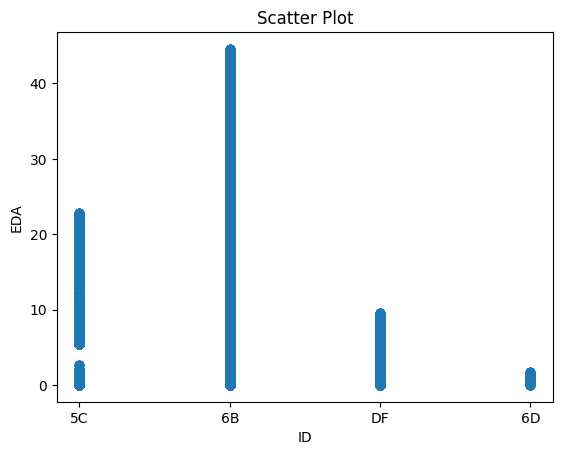

In [7]:
import matplotlib.pyplot as plt

# Create a mapping dictionary for the ids
unique_ids = df['id'].unique()
id_map = {id_val: i+1 for i, id_val in enumerate(unique_ids)}

# Create a new column with the mapped values
df['id_num'] = df['id'].map(id_map)

# Create a scatter plot with the x-axis scaled to the unique id_num values
plt.scatter(df['id_num'], df['EDA'])

# Set the x-axis tick locations and labels
plt.xticks(range(1, len(unique_ids)+1), unique_ids)

# Add axis labels and a title
plt.xlabel('ID')
plt.ylabel('EDA')
plt.title('Scatter Plot')

# Show the plot
plt.show()

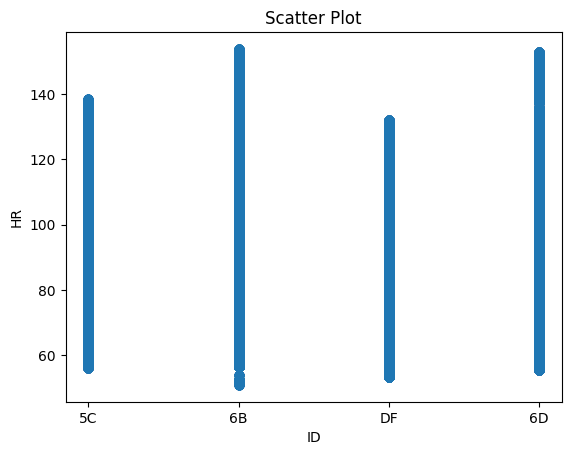

In [8]:
# Create a scatter plot with the x-axis scaled to the unique id_num values
plt.scatter(df['id_num'], df['HR'])

# Set the x-axis tick locations and labels
plt.xticks(range(1, len(unique_ids)+1), unique_ids)

# Add axis labels and a title
plt.xlabel('ID')
plt.ylabel('HR')
plt.title('Scatter Plot')

# Show the plot
plt.show()

Small amount of data but could not draw any conclusions from it, so decided to merge all of the data together

In [29]:
df = pd.read_csv('/content/gdrive/MyDrive/DS/Data/merged_data_labeled.csv')
df.head()

<ipython-input-29-11c45c191402>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/gdrive/MyDrive/DS/Data/merged_data_labeled.csv')


,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0


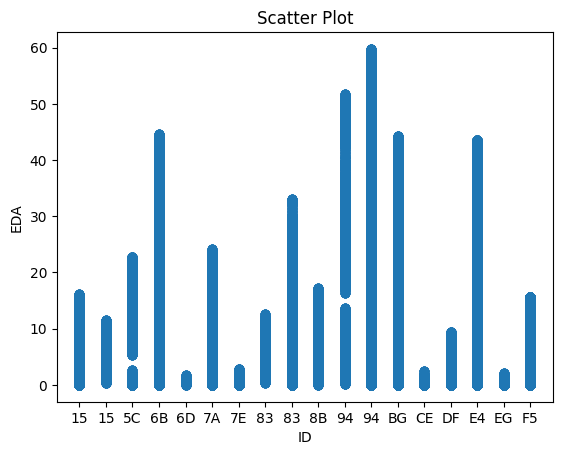

In [20]:
import matplotlib.pyplot as plt

# Create a mapping dictionary for the ids
unique_ids = df['id'].unique()
id_map = {id_val: i+1 for i, id_val in enumerate(unique_ids)}

# Create a new column with the mapped values
df['id_num'] = df['id'].map(id_map)

# Create a scatter plot with the x-axis scaled to the unique id_num values
plt.scatter(df['id_num'], df['EDA'])

# Set the x-axis tick locations and labels
plt.xticks(range(1, len(unique_ids)+1), unique_ids)

# Add axis labels and a title
plt.xlabel('ID')
plt.ylabel('EDA')
plt.title('Scatter Plot')

# Show the plot
plt.show()

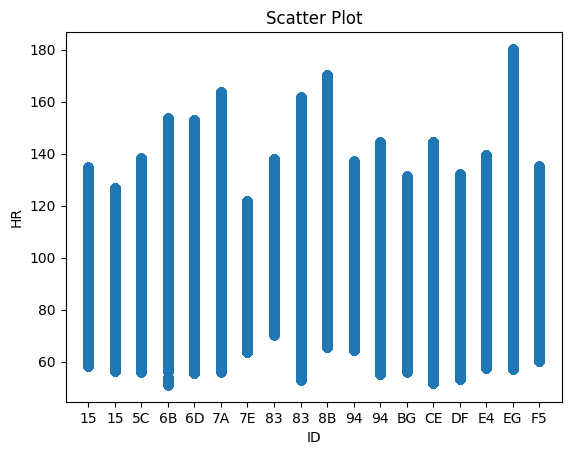

In [21]:
# Create a scatter plot with the x-axis scaled to the unique id_num values
plt.scatter(df['id_num'], df['HR'])

# Set the x-axis tick locations and labels
plt.xticks(range(1, len(unique_ids)+1), unique_ids)

# Add axis labels and a title
plt.xlabel('ID')
plt.ylabel('HR')
plt.title('Scatter Plot')

# Show the plot
plt.show()

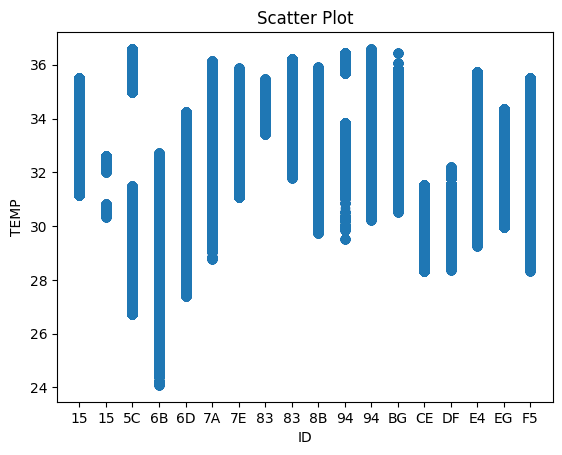

In [22]:
# Create a scatter plot with the x-axis scaled to the unique id_num values
plt.scatter(df['id_num'], df['TEMP'])

# Set the x-axis tick locations and labels
plt.xticks(range(1, len(unique_ids)+1), unique_ids)

# Add axis labels and a title
plt.xlabel('ID')
plt.ylabel('TEMP')
plt.title('Scatter Plot')

# Show the plot
plt.show()

In [30]:
from sklearn.preprocessing import StandardScaler

# Check for missing values
print(df.isnull().sum())

# Check for duplicates
print(df.duplicated().sum())
df=df.drop_duplicates()


X           0
Y           0
Z           0
EDA         0
HR          0
TEMP        0
id          0
datetime    0
label       0
dtype: int64
105606


<ipython-input-23-5a43a2688479>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


               X         Y         Z       EDA        HR      TEMP     label  \
X       1.000000  0.067204  0.197295  0.093888  0.126070  0.022847 -0.008351   
Y       0.067204  1.000000  0.019084 -0.096138 -0.068020 -0.084576 -0.022143   
Z       0.197295  0.019084  1.000000  0.005993 -0.104191 -0.029366 -0.058655   
EDA     0.093888 -0.096138  0.005993  1.000000  0.142542  0.352888  0.053214   
HR      0.126070 -0.068020 -0.104191  0.142542  1.000000  0.158172 -0.032983   
TEMP    0.022847 -0.084576 -0.029366  0.352888  0.158172  1.000000  0.135259   
label  -0.008351 -0.022143 -0.058655  0.053214 -0.032983  0.135259  1.000000   
id_num  0.291566  0.089410  0.040344  0.085625 -0.032966  0.145106  0.239522   

          id_num  
X       0.291566  
Y       0.089410  
Z       0.040344  
EDA     0.085625  
HR     -0.032966  
TEMP    0.145106  
label   0.239522  
id_num  1.000000  


<Axes: >

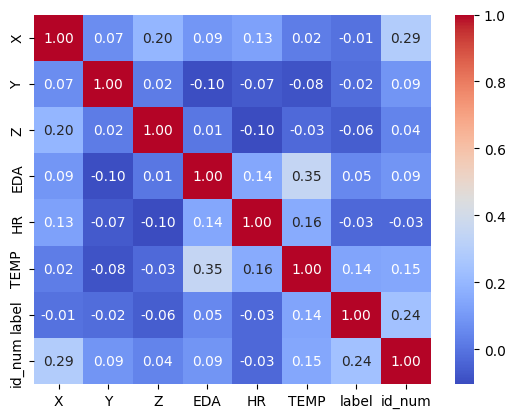

In [23]:
# Get the correlation matrix
correlation_matrix = df.corr()
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f')

Model Building

In [24]:
X = df[['EDA', 'HR', 'TEMP']]
y = df['label']

In [25]:
# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a machine learning model
clf = LogisticRegression()

# Train the model on the training set
clf.fit(X_train, y_train)

LogisticRegression()

In [27]:
# Evaluate the model on the testing set
y_pred = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred, average = 'macro')
recall    = recall_score    (y_test, y_pred, average = 'macro')
precision = precision_score (y_test, y_pred, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred)

print('acc =', accuracy)
print('pre =', precision)
print('recall =', recall) 
print('f1 =', f1score)

acc = 0.7423307126432187
pre = 0.24746034194235597
recall = 0.3333029037079864
f1 = 0.2840374322572623


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Achived accuracy of 74.23%